In [7]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from main import SimCLR
from backbones import get_backbone
from evaluation import get_dataset

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
MODEL = "MICRA-Net"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False

if MODEL == "simclr-resnet18-STED":
    transform = None
    backbone = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    transform = None
    backbone = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
# print(model)
print("Model loaded")

/tmp/ipykernel_1065879/2555781474.py:29: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_1065879/2555781474.py:30: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_1065879/2555781474.py:36: UserWarning: Overwriting the cmap 'green-magenta' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_1065879/2555781474.py:37: UserWarning: Overwriting the cmap 'green-magenta_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)


Model loaded


In [11]:
dataset = get_dataset("factin-block-glugly", transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Dataset(F-actin) -- length: 295
Block - 119
GLU-GLY - 176



# KNN

In [12]:
out = defaultdict(list)
for x, label in tqdm(dataloader):
    features = model.backbone(x).flatten(start_dim=1)
    for key, values in label.items():
        out[key].extend(values.cpu().data.numpy().tolist())
    out["features"].extend(features.cpu().data.numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:49<00:00,  2.62s/it]


Accuracy: 87.64


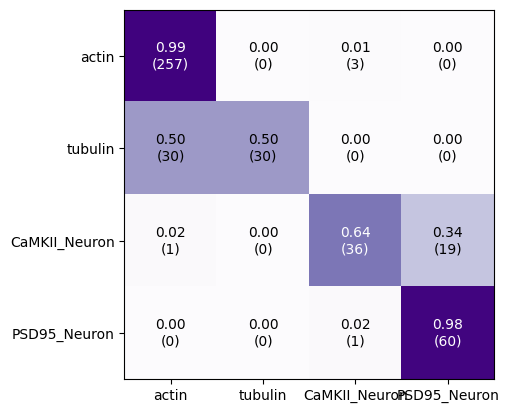

In [10]:
from sklearn.neighbors import NearestNeighbors
SHOW_MISSED = False

samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])

neigh = NearestNeighbors(n_neighbors=6, metric="minkowski", p=2)
neigh.fit(samples)

# 1st nn is itself
neighbors = neigh.kneighbors(samples, return_distance=False)[:, 1:]
associated_labels = labels[neighbors]

# accuracy = numpy.sum(associated_labels == labels[:, numpy.newaxis], axis=-1)
uniques = numpy.unique(labels)
confusion_matrix = numpy.zeros((len(uniques), len(uniques)))
for unique in uniques:
    mask = labels == unique
    for predicted_unique in uniques:
        votes = numpy.sum((associated_labels[mask] == predicted_unique).astype(int), axis=-1)
        confusion_matrix[unique, predicted_unique] += numpy.sum(votes >= 3)
        if SHOW_MISSED and (unique != predicted_unique) and (numpy.sum(votes >= 3) > 0):
            print(unique, predicted_unique)
            for idx, associated in zip(indices[mask][votes >= 3], associated_labels[mask][votes >= 3]):
                img, metadata = dataset[idx]
                img = img[0].cpu().data.numpy()
                
                fig, ax = pyplot.subplots(figsize=(3,3))
                ax.imshow(img, cmap="hot", vmin=0, vmax=1)
                ax.set_title(associated)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                pyplot.show()
                

accuracy = numpy.diag(confusion_matrix).sum() / numpy.sum(confusion_matrix)
print(f"Accuracy: {accuracy * 100:0.2f}")
        
fig, ax = pyplot.subplots()
cm = confusion_matrix / numpy.sum(confusion_matrix, axis=-1)[:, numpy.newaxis]
ax.imshow(cm, vmin=0, vmax=1, cmap="Purples")
for j in range(cm.shape[-2]):
    for i in range(cm.shape[-1]):
        ax.annotate(
            f"{cm[j, i]:0.2f}\n({confusion_matrix[j, i]:0.0f})", (i, j), 
            horizontalalignment="center", verticalalignment="center",
            color="white" if cm[j, i] > 0.5 else "black"
        )
ax.set(
    xticks=uniques, yticks=uniques,
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
pyplot.show()